# Demo - Sensitivity check with Iris Data

In [1]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
from torchhk.vis import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load Iris Data

In [3]:
iris = datasets.load_iris()

In [4]:
X = iris.data
Y = iris.target 

In [5]:
x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
x.shape, y.shape

(torch.Size([150, 4]), torch.Size([150]))

## 2. Define Model

In [6]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

## 3. Train Model

### 3.1. Sensitivity to KL loss

In [7]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=100, out_features=3),
)


optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
kl_weight = 0.1

In [9]:
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 98.666667 %
- CE : 0.21, KL : 2.40


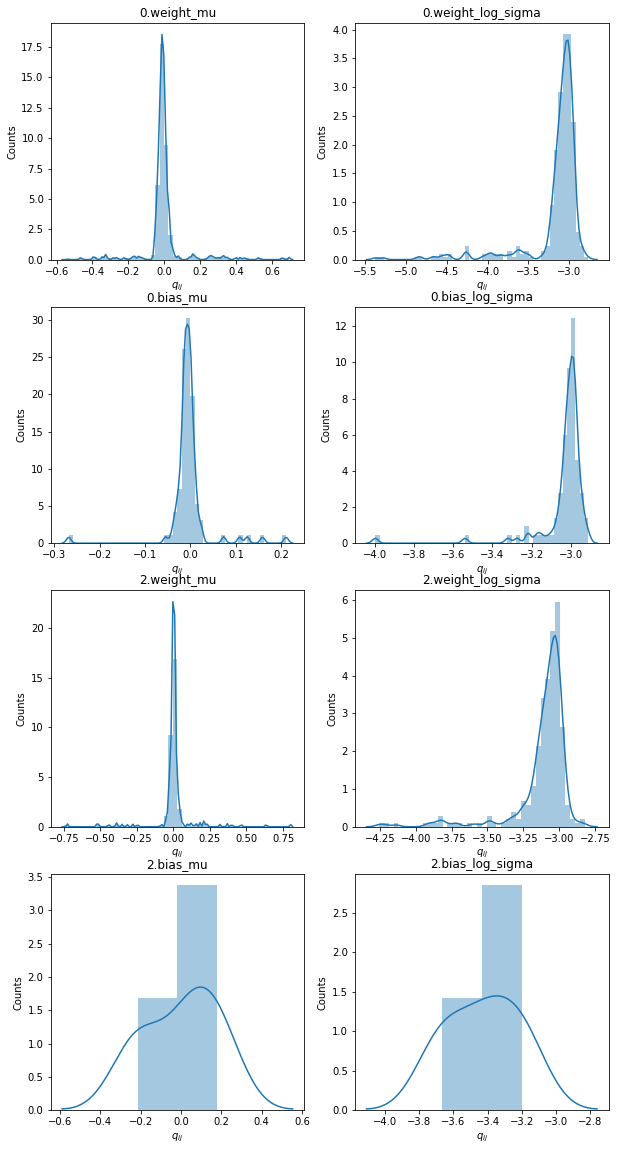

In [10]:
plot_individual_weight(model)

### 3.2. Custom KL loss

In [11]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=100, out_features=3),
)


optimizer = optim.Adam(model.parameters(), lr=0.01)

In [12]:
def custom_kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    kl = (log_sigma_0**2 + (mu_0-mu_1)**2)/(2*log_sigma_1**2)
    return kl.sum()

In [13]:
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    
    # custom kl loss
    ckl = 0
    n = 0
    
    for m in model.modules() :
        if isinstance(m, (bnn.BayesLinear, bnn.BayesConv2d)):
            kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                m.prior_mu, m.prior_log_sigma)
            ckl += kl
            n += len(m.weight_mu.view(-1))

            if m.bias :
                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.bias_mu.view(-1))

        if isinstance(m, bnn.BayesBatchNorm2d):
            if m.affine :
                kl = custom_kl_loss(m.weight_mu, m.weight_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl
                n += len(m.weight_mu.view(-1))

                kl = custom_kl_loss(m.bias_mu, m.bias_log_sigma,
                                    m.prior_mu, m.prior_log_sigma)
                ckl += kl                
                n += len(m.bias_mu.view(-1))
    
    cost = ce + kl_weight*ckl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 94.666667 %
- CE : 0.09, KL : 0.14


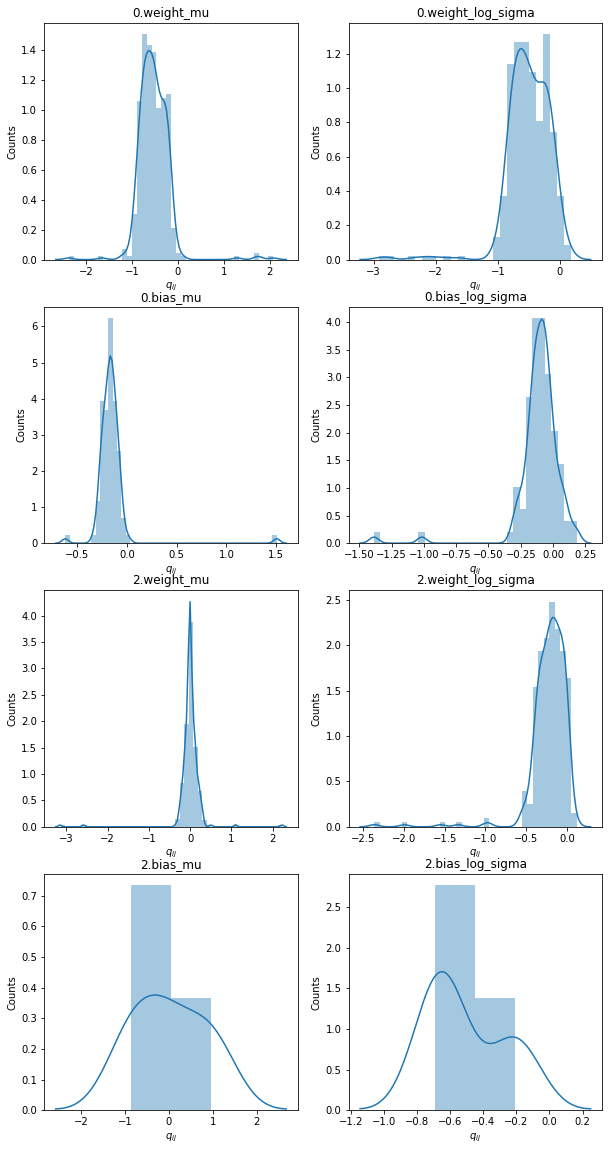

In [14]:
plot_individual_weight(model)